# Machine Learning for Single-Cell Biology
***

Winter Semester 2025/26<br />
Manfred Claassen, Maximilian Wirth, Jan Schleicher
<br />
***

## Assignment 1

In [223]:
import numpy as np 
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
from scipy.stats import mode

import os
from utils import import_mtx_expression_data
from typing import Tuple

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("ticks")

%matplotlib inline

In [224]:
DATA_PATH = "data/"
OUTPUT_PATH = "output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

### Task 1

In [225]:
# Load the data
expression_data_1 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_1.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_1_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_1_genes.tsv"))
metadata_1 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_1_metadata.tsv"), sep="\t", index_col=0)

# If required, perform preprocessing of the data
#########################
# computing indices for organ group
# group_A_organ = metadata_1[metadata_1["new_sampleID"] == "A"].index
# group_B_organ = metadata_1[metadata_1["new_sampleID"] == "B"].index
# group_C_organ = metadata_1[metadata_1["new_sampleID"] == "C"].index
# group_D_organ = metadata_1[metadata_1["new_sampleID"] == "D"].index
# group_E_organ = metadata_1[metadata_1["new_sampleID"] == "E"].index
# group_F_organ = metadata_1[metadata_1["new_sampleID"] == "F"].index

# # computing indices for celltype group
# group_T1_cells = metadata_1[metadata_1["new_pheno"] == "T1"].index
# group_T2_cells = metadata_1[metadata_1["new_pheno"] == "T2"].index
# group_T3_cells = metadata_1[metadata_1["new_pheno"] == "T3"].index
# group_T4_cells = metadata_1[metadata_1["new_pheno"] == "T4"].index
# group_T5_cells = metadata_1[metadata_1["new_pheno"] == "T5"].index

# computing means for each organ group
organ_means = {}
for organID in metadata_1["new_sampleID"].unique(): 
    organ_indices = metadata_1[metadata_1["new_sampleID"] == organID].index
    organ_means[organID] = expression_data_1.loc[organ_indices].mean(axis=0)

organ_means_df = pd.DataFrame(organ_means)

# computing means for each cell type group
cell_type_means = {}
for cellID in metadata_1["new_pheno"].unique(): 
    cell_indices = metadata_1[metadata_1["new_pheno"] == cellID].index
    cell_type_means[cellID] = expression_data_1.loc[cell_indices].mean(axis=0)

cell_type_mean_df = pd.DataFrame(cell_type_means)

# data frame for the means of all cell-states -> used as reference
cell_state_mean_df = pd.DataFrame(columns=cell_type_mean_df.columns)






#########################

In the preprocessing step, we first extracted the indices of the anonymous cell-type and organ-type groups using the metadata file. 

For each type in cell_types and each organ in organ_type, we computed the mean values: e.g. we computed the means for cell-type group T1, T2, ... and the same for organ-type A,B,C,...

For later use we stored these mean values columnswise in a dataframe.

In [226]:
def task1a_identification(expression_data: pd.DataFrame, metadata: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyze the data to identify cell types and organs
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param metadata: metadata containing cell groupings and sample IDs
    :return: organ and cell type identities
    """
    organ_identity = {"A": "blood", "B": "LN", "C": "BM", "D": "spleen", "E": "liver", "F": "lung"}
    cell_type_identity = {"T1": "E", "T2": "I", "T3": "P", "T4": "M", "T5": "Exh"}

    #########################
    expression_data_ref = pd.DataFrame(columns=cell_type_mean_df.columns)
    
    # analyzing cell_types -> we look at the means for each group and compare manually to the data provided in the paper
    # P: Proliferation state, Mad2l1, Birc5, Mki67, Ki-67, Cdc8a, Cdc3, Cks1b, Cks2, Mcm2, Mcm3, Lig1, E2f1, Mybl2, Maz, E2f1
    # M: Memory cells -> only found in spleen and LNs 
    # E: Effector like -> mostly found in lungs, blood and spleen 
    # I: Intermediate -> 
    # Exh: Advanced exhaustion -> found in all tissues at different frequencies. Most cells in BM and liver, low number in Lungs 
    cell_states = {
        "P": ["Mad2l1", "Birc5", "Mki67", "Ki-67", "Cdc8a", "Cdc3", "Cks1b", "Cks2", "Mcm2", "Mcm3", "Lig1", "E2f1", "Mybl2", "Maz", "E2f1"],
        "M":["Tcf7", "TCF1", "Id3", "Cd28", "Ccr7", "Slamf6", "Ly108", "Cxcr5", "Il7r", "Sell", "Xcl1 ", "Cxcl10", "Cxcr3", "Icos", "Cxcr4"], # but low expression of: Tbx21, Id2, Zeb2
        "E":["Prf1", "Gzmb", "Klf2", "Zeb2", "Tbx21", "Cx3cr1", "Klre1", "Klrk1", "Id2",  "Itgb7", "Emp3", "Itgax", "Itgb1", "Itgb2", "Itgal", "Itga4", "Itgam", "Itgax", "Ly6c", "Klf2", "S1pr1", "S1pr4"],
        "I":["Tox", "Cxcr3", "Cxcr6", "Zeb2", "Pdcd1", "Lag3", "Cd160", "Cd244", "Cd200r1", "Nr4a1", "Cd7"],
        "Exh":["Gzma", "Gzmk", "Pdcd1", "Cd160", "Cd244", "Lag3", "Eomes", "Cxcr6", "Tox", "Pdcd1", "Cd160", "Cd244", "Cd200r1", "Lag3", "Cxcr3", "Cd7", "Il21r", "Irf7", "Stat1", "Stat2", "Irf9"] # lower Il18r1 and Il18rap
    }

    important_genes_for_organs = {"Pdcd1", "Nr4a1", "Cx3cr1", "Cxcr6", "Gzmb", "Cxcr3", "Irf7", "Stat1", "Stat2", "Irf9", "Tcf7", "Mki67", "Slamf6"}

    # Liver:    (for Exh) Nr4a1, Nfkbid, Jun, Jund (lower)
    # BM:       (for Exh) Ngp, Camp, S110a9, S110a8 (higher)
    # Spleen:   (for Exh) kB, Junb (higher)
    # Blood:    (for Exh) Gzma (higher)
    # Lung:     (for Exh)
    # LN:       (for Exh)

    # Liver:    (for E) 
    # BM:       (for E) 
    # Spleen:   (for E) Nr4a1, Jun, Jund, Nfkbiz, Nfbid (higher)
    # Blood:    (for E) Nr4a1 and Cd69 (lower)
    # Lung:     (for E) Nr4a1, Jun, Jund, Nfkbiz, Nfbid (higher)
    # LN:       (for E) Nr4a1, Jun, Jund, Nfkbiz, Nfbid (higher)

    # iterating over dictionary to get important genes
    cell_state_mean_df = pd.DataFrame(columns=cell_type_mean_df.columns)
    
    for state, genes in cell_states.items():
        existing_genes = [g for g in genes if g in cell_type_mean_df.index]

        state_means = cell_type_mean_df.loc[existing_genes].mean(axis=0)
        cell_state_mean_df.loc[state] = state_means

    display(cell_state_mean_df)

    # existing_genes_P = [g for g in cell_states["P"] if g in cell_type_mean_df.index]
    # P_gene_means = cell_type_mean_df.loc[existing_genes_P].mean(axis=0)
    # expression_data_ref.loc["P"] = P_gene_means

    # existing_genes_M = [g for g in cell_states["M"] if g in cell_type_mean_df.index]
    # M_gene_means = cell_type_mean_df.loc[existing_genes_M].mean(axis=0)
    # expression_data_ref.loc["M"] = M_gene_means

    # existing_genes_E = [g for g in cell_states["E"] if g in cell_type_mean_df.index]
    # E_gene_means = cell_type_mean_df.loc[existing_genes_E].mean(axis=0)
    # expression_data_ref.loc["E"] = E_gene_means

    # existing_genes_I = [g for g in cell_states["I"] if g in cell_type_mean_df.index]
    # I_gene_means = cell_type_mean_df.loc[existing_genes_I].mean(axis=0)
    # expression_data_ref.loc["I"] = I_gene_means

    # existing_genes_Exh = [g for g in cell_states["Exh"] if g in cell_type_mean_df.index]
    # Exh_gene_means = cell_type_mean_df.loc[existing_genes_Exh].mean(axis=0)
    # expression_data_ref.loc["Exh"] = Exh_gene_means


    # I would do the following mapping for cell-types
    # P -> The table containing all upregulated genes for Profileration shows that the highest expression levels are within group T3
    # M -> The table containing all upregulated genes for Memory-Cells shows that the highest expression levels are within group T4
    # E -> The table containing all upregulated genes for Expression shows that the highest expression levels are within group T1 -> especcialy because Cx3cr1 is high, which according to the paper allows for distinction between T_E and T_Exh
    # I -> The table containing all upregulated genes for Intermediate shows that the highest expression levels are within group T2
    # Exh -> The table containing all upregulated genes for Exhausted shows that the highest expression levels are within group T5


    # Mapping organs
    organ_type_means_df = pd.DataFrame(columns=organ_means_df.columns)

    organ_genes = [g for g in important_genes_for_organs if g in organ_means_df.index]
    important_organs = organ_means_df.loc[organ_genes]

    # Looking at the genes, important for the organs (looking at figure 4 of the paper), we can see: 
    # NUR77 -> Nr4a1; PD1 -> Pdcd1; IFN -> Irf7, Irf9, Stat1, Stat2; Ly108 -> Slamf6; TCF-1 -> Tcf7, Ki-67 -> Mki67

    display(important_organs)
    #########################

    return pd.DataFrame.from_dict(organ_identity, orient="index"),\
           pd.DataFrame.from_dict(cell_type_identity, orient="index")

For this task, we first needed to read through the given research paper, to find out which genes are upregulated (or downregulated) for specific cell-states and also organs.

Especially this section was very helpful in understanding and deriving, which genes were up or downregulated: Factor Analysis Reveals Five Main Phenotypes with Distinct Transcriptional Signatures Regarding TCR Activation and Inhibition, Trafficking, and IL Receptors, Sandu, Ioana et al.Cell Reports, Volume 32, Issue 8, 108078. This section had a very detailed description of how and which genes were upregulated or downregulated in certain cell-states.

The reading resulted in the manual generation of the cell_states dictionary. 
Now we used this dictionary to look at all each cell state and each gene and compute the mean expression level using the previously generated dataframe of the mean expression levels for each gene, by referring to their indices and locating them in the dataframe. 

Next we have generated a dataframe with a mapping of the cell-type means to the anonymous cell-types. 
In the last step the mean expression levels were compared manually with each other, and those columns of the dataframe/matrix were chosen, which had the highest value for a certain row (row = cell-state). 

The same has been done for the mapping of the organ types to the anonymous organ-types (A to E).
For this task Figure 4 of the previously mentioned paper was used for comparison. For comparison the number of groups occuring most often were denoted by hand and then compared to the plot in figure 4 of the paper to manually assing the actual groups to the anonymous organs.

In [227]:
task1a_organ_identity, task1a_cell_type_identity = task1a_identification(expression_data_1, metadata_1)

task1a_organ_identity.to_csv(os.path.join(OUTPUT_PATH, "task1a_organ_identity.txt"), sep="\t", header=False)
task1a_cell_type_identity.to_csv(os.path.join(OUTPUT_PATH, "task1a_cell_type_identity.txt"), sep="\t", header=False)

display(task1a_organ_identity)
display(task1a_cell_type_identity)

,T2,T1,T3,T5,T4
P,0.222753,0.236993,0.364855,0.331215,0.342509
M,0.279249,0.232031,0.383213,0.334958,0.473554
E,1.556206,2.548849,2.361422,2.245763,2.231865
I,2.324815,1.498308,1.930896,2.052542,1.930052
Exh,2.836219,2.144681,2.450345,2.431275,2.255058


,D,A,C,B,F,E
0,,,,,,
Tcf7,0.027604,0.258021,0.013580,0.438020,0.073390,0.009712
Cxcr6,3.656975,3.084559,5.724335,5.017055,2.369695,4.628392
Slamf6,0.030548,0.383356,0.048072,0.780366,0.069895,0.038846
Gzmb,12.062937,5.168783,6.100217,14.050749,9.702197,5.502999
Nr4a1,0.225985,0.928142,0.354155,1.332779,0.433100,0.011711
Cxcr3,0.776960,0.950201,1.064639,1.473378,0.442336,1.070266
Mki67,0.198381,0.115642,0.200435,0.530366,0.205691,0.099115
Irf9,0.444976,0.378342,0.446225,0.621464,0.325761,0.328192
Irf7,0.458594,0.643717,0.861217,1.066972,0.497254,0.438732


,0
A,blood
B,LN
C,BM
D,spleen
E,liver
F,lung


,0
T1,E
T2,I
T3,P
T4,M
T5,Exh


In [228]:
# Load the data
expression_data_2 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_2.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_2_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_2_genes.tsv"))

# If required, perform preprocessing of the data
#########################
cell_states = {
        "P": ["Mad2l1", "Birc5", "Mki67", "Ki-67", "Cdc8a", "Cdc3", "Cks1b", "Cks2", "Mcm2", "Mcm3", "Lig1", "E2f1", "Mybl2", "Maz", "E2f1"],
        "M":["Tcf7", "TCF1", "Id3", "Cd28", "Ccr7", "Slamf6", "Ly108", "Cxcr5", "Il7r", "Sell", "Xcl1 ", "Cxcl10", "Cxcr3", "Icos", "Cxcr4"], # but low expression of: Tbx21, Id2, Zeb2
        "E":["Prf1", "Gzmb", "Klf2", "Zeb2", "Tbx21", "Cx3cr1", "Klre1", "Klrk1", "Id2",  "Itgb7", "Emp3", "Itgax", "Itgb1", "Itgb2", "Itgal", "Itga4", "Itgam", "Itgax", "Ly6c", "Klf2", "S1pr1", "S1pr4"],
        "I":["Tox", "Cxcr3", "Cxcr6", "Zeb2", "Pdcd1", "Lag3", "Cd160", "Cd244", "Cd200r1", "Nr4a1", "Cd7"],
        "Exh":["Gzma", "Gzmk", "Pdcd1", "Cd160", "Cd244", "Lag3", "Eomes", "Cxcr6", "Tox", "Pdcd1", "Cd160", "Cd244", "Cd200r1", "Lag3", "Cxcr3", "Cd7", "Il21r", "Irf7", "Stat1", "Stat2", "Irf9"] # lower Il18r1 and Il18rap
}

cell_state_mean_df = pd.DataFrame(columns=cell_type_mean_df.columns)
    
for state, genes in cell_states.items():
    existing_genes = [g for g in genes if g in cell_type_mean_df.index]
    state_means = cell_type_mean_df.loc[existing_genes].mean(axis=0)
    cell_state_mean_df.loc[state] = state_means

expression_data_ref = cell_state_mean_df
display(expression_data_ref)

metadata_ref = task1a_cell_type_identity
display(metadata_ref)
#########################

,T2,T1,T3,T5,T4
P,0.222753,0.236993,0.364855,0.331215,0.342509
M,0.279249,0.232031,0.383213,0.334958,0.473554
E,1.556206,2.548849,2.361422,2.245763,2.231865
I,2.324815,1.498308,1.930896,2.052542,1.930052
Exh,2.836219,2.144681,2.450345,2.431275,2.255058


,0
T1,E
T2,I
T3,P
T4,M
T5,Exh


In [229]:
from sklearn.metrics.pairwise import cosine_similarity

def task1b_annotation(expression_data: pd.DataFrame, expression_data_ref: pd.DataFrame, metadata_ref) -> pd.DataFrame:
    """
    Annotate each cell with its corresponding cell type
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param expression_data_ref: reference expression matrix of shape (n_cells_ref, n_genes)
    :param metadata_ref: reference metadata with n_cells_ref rows and a column containing true cell types for expression_data_ref
    :return: cell type annotations for expression_data
    """
    # cell_annotations = pd.DataFrame(index=expression_data.index.values, columns=["phenotype"])
    display(expression_data)
    display(expression_data_ref)

    similarity_matrix = cosine_similarity(expression_data, expression_data_ref)
    similarities_df = pd.DataFrame(
        similarity_matrix, 
    )

   # display(similarities_df)

    predicted_labels = similarities_df.idxmax(axis=1)
    cell_annotations = pd.DataFrame()
    for idx in predicted_labels.index: 
        ref_idx = predicted_labels[idx]
        meta_data_cell_type_from_exp_data_1= metadata_ref.iloc[ref_idx]["new_pheno"]
        cell_type_expr2 = task1a_cell_type_identity.loc[meta_data_cell_type_from_exp_data_1, 0]
        cell_annotations.at[idx, "phenotype"] = cell_type_expr2



    # display(predicted_labels)
    # display(metadata_ref)
    # display(metadata_ref.iloc[2000]["new_pheno"])

    display(cell_annotations)
    
    return cell_annotations

In this task,we first investigated the method arguments. We saw, that both expression_data and epxression_data_ref (later called with expression_data2 and expression_data1) contained a matrix consisting of cells as rows and respective genes as columns.

Since we previously in task 1A had already computed a mapping from the anonymous cell-types to the actual cell-types, we did the following: 

We first computed the similarity between both matrices using cosine-similarity, to see, which rows are more similar to each other. This resulted in the similarity matrix. Now that we had a mapping between expression_data and the reference expression data, we were able to look into the metadata from task 1. Here we used the mapping from expression2 rows to expression1 rows to select for each cell in expression2 the corresponding "new_pheno" column with the anonymous cell_type. 

As a last step, we needed to use the previously computed mapping of anonymous cell-types to the actual cell-types form task 1A. Doing this for each row in expression2 resulted in the cell_annotations.

**Please also submit the output CSV file with the annotations for Task 1b!**

In [230]:
task1b_cell_annotations = task1b_annotation(expression_data_2, expression_data_1, metadata_1)
task1b_cell_annotations.to_csv(os.path.join(OUTPUT_PATH, "task1b_cell_annotations.txt"), sep="\t")

,Gm19938,Mrpl15,Gm37144,Lypla1,Gm37988,Tcea1,Atp6v1h,Gm37567,Oprk1,Rb1cc1,...,Tmlhe,AC133103.1,AC132444.1,Csprs,AC125149.3,AC125149.2,AC168977.1,AC149090.1,CAAA01118383.1,CAAA01147332.1
0,,,,,,,,,,,,,,,,,,,,,
D_AAACGGGGTAGCGTAG,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
D_AAACGGGGTCTAGTCA,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
D_AAAGATGAGTATTGGA,0,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
D_AAAGATGTCATAGCAC,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D_AAAGCAAAGGATCGCA,0,0,0,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E_TTTATGCCAGTACACT,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
E_TTTGCGCGTTTGCATG,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E_TTTGCGCTCTAACTTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


,Gm19938,Mrpl15,Gm37144,Lypla1,Gm37988,Tcea1,Atp6v1h,Gm37567,Oprk1,Rb1cc1,...,Tmlhe,AC133103.1,AC132444.1,Csprs,AC125149.3,AC125149.2,AC168977.1,AC149090.1,CAAA01118383.1,CAAA01147332.1
0,,,,,,,,,,,,,,,,,,,,,
D_ACACCAAAGTACACCT,0,5,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D_TGGACGCGTGTAATGA,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
D_TGCTACCCAATCTACG,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D_CATGACAAGGGAAACA,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
D_ATCACGAGTAGGAGTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E_GTCCTCAGTTGTACAC,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E_TGACAACCACAGACTT,0,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
E_CGGAGTCGTGCGAAAC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,phenotype
0,I
1,I
2,I
3,E
4,I
...,...
4821,I
4822,I
4823,I
4824,I


### Task 2

In [231]:
cell_sequences = np.load(os.path.join(DATA_PATH, "tex_sampling.npy"))
metadata_3 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_3_metadata.txt"), sep="\t", index_col=0)
expression_data_3 = import_mtx_expression_data(os.path.join(DATA_PATH, "expression_data_3.mtx"),
                                               os.path.join(DATA_PATH, "expression_data_3_barcodes.tsv"),
                                               os.path.join(DATA_PATH, "expression_data_3_genes.tsv"))

In [232]:
def task2a_trajectory_analysis(sequences: np.ndarray, metadata: pd.DataFrame) -> Tuple[list, list]:
    """
    Identify an ordering of louvain clusters along the two trajectories
    :param sequences: numpy array of cell sequences (cell indices, corresponding to rows of metadata) of shape
    (n_sequences, n_steps)
    :param metadata: cell metadata with louvain clusters
    :return: orderings of louvain clusters along the two trajectories
    """
    upper_trajectory_louvain_ordering = []
    lower_trajectory_louvain_ordering = []

    #our code
    #first step: we replace each cell in cell_sequences with its cluster from metadata_3
    clusters_array = metadata['louvain'].to_numpy()
    cluster_sequences = clusters_array[cell_sequences]  
    
    #second step: we define the last cluster in each sequence
    last_cluster = cluster_sequences[:, -1] 
    #we select the two last clusters with the highest fequencies to define the trajectories clusters
    trajectory_cluster, counts = np.unique(last_cluster, return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]
    chosen_clusters = trajectory_cluster[sorted_indices[:2]]  
    upper_trajectory_cluster = chosen_clusters[0]  
    lower_trajectory_cluster = chosen_clusters[1]  
    
    #third step: we split the squences into upper and lower trajectories
    upper_sequences = cluster_sequences[last_cluster == upper_trajectory_cluster]
    # display(upper_sequences)
    lower_sequences = cluster_sequences[last_cluster == lower_trajectory_cluster]
    #we extract the most frequent clusters along the sequences
    upper_trajectory_louvain_ordering = mode(upper_sequences, axis=0)[0]
    #display(mode(upper_sequences))
    # display(mode(upper_sequences, axis=0).mode[0])
    
    lower_trajectory_louvain_ordering = mode(lower_sequences, axis=0)[0]

    return upper_trajectory_louvain_ordering, lower_trajectory_louvain_ordering

We first replaced each cell in tex_sampling.npy with the corresponding cluster from expression_meta_3_metadata.txt.
Now, we look at the last cluster in each sequence, we have three but we choose the two most repeated clusters because we only want two trajectories.
We assign the most repeated cluster to the upper trajectory and the second repeated one to the lower trajectory.
Next, we split the sequences to upper and lower trajectory sequences based on their final cluster.
Finally, for the upper trajectory sequences we look for the most repeated cluster in every position (0 to 49) and select it for the final cluster sequence. we do the same for lower trajectory sequences.
And we get the sequence of Louvain clusters for each trajectory.

**Please also submit the output files with the cluster orderings for Task 2a!**

In [233]:
task2a_upper_trajectory, task2a_lower_trajectory = task2a_trajectory_analysis(cell_sequences, metadata_3)
pd.DataFrame(task2a_upper_trajectory).to_csv(os.path.join(OUTPUT_PATH, "task2a_upper_trajectory.txt"), header=False)
pd.DataFrame(task2a_lower_trajectory).to_csv(os.path.join(OUTPUT_PATH, "task2a_lower_trajectory.txt"), header=False)

In [ ]:
def task2b_correlation_analysis(expression_data: pd.DataFrame, metadata: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the correlation of each gene's expression with sample ID
    :param expression_data: expression matrix of shape (n_cells, n_genes)
    :param metadata: metadata containing sample IDs (column name sampleID)
    :return: data frame with correlation and p value for each gene
    """
    gene_correlations = pd.DataFrame(data=np.ones((expression_data.shape[1], 3)), index=expression_data.columns.values,
                                     columns=["correlation", "abs_correlation", "p_value"])


    #########################
    sampleID_vector = metadata["sampleID"].values
    
    for gene in expression_data.columns: 
        gene_expr = expression_data[gene].values

        corr, p = stats.spearmanr(gene_expr, sampleID_vector)

        gene_correlations.loc[gene, "correlation"] = corr
        gene_correlations.loc[gene, "abs_correlation"] = abs(corr)
        gene_correlations.loc[gene, "p_value"] = p
    
    #########################
    display(gene_correlations)
    
    return gene_correlations

In this task we used the provided metadata to extract the needed sampleIDs. 

With then for each gene in the expression_data, we extracted the expression levels and computed the correlation an p-value using the spearman correlation from the spearmanr library of scipy.stats package. 

We then inserted the values in to the provided dataframe called "gene_correlations", by referring to the location of the genes in the dataframe

To get the top 10 correlating genes, we used the abs_correlation column of the provided dataframe, sorted it by descending order and took the first 10 entries with .head(10)

The top resulting genes are reported in the dataframe below.

**Please also submit the output CSV file with the correlations for Task 2b!**

,correlation,abs_correlation,p_value
Mrpl15,-0.392258,0.392258,0.000000e+00
Mcm3,-0.491959,0.491959,0.000000e+00
Prim2,-0.234628,0.234628,1.291217e-170
Aff3,-0.026442,0.026442,1.971164e-03
Nab1,-0.108701,0.108701,2.851966e-37
...,...,...,...
Maoa,-0.168532,0.168532,8.628555e-88
Dkc1,-0.488142,0.488142,0.000000e+00
Kif4,-0.228300,0.228300,2.117543e-161
Cenpi,-0.163912,0.163912,4.405613e-83


,correlation,abs_correlation,p_value
Malat1,0.815616,0.815616,0.0
Rps2,-0.738947,0.738947,0.0
Cd3g,0.678322,0.678322,0.0
2810417H13Rik,-0.613293,0.613293,0.0
Birc5,-0.582989,0.582989,0.0
Ybx1,-0.576375,0.576375,0.0
Dut,-0.572940,0.572940,0.0
Ddx39,-0.570424,0.570424,0.0
Anp32b,-0.566921,0.566921,0.0
Lyar,-0.556102,0.556102,0.0


Top 10 correlating genes


,correlation,abs_correlation,p_value
Malat1,0.815616,0.815616,0.0
Rps2,-0.738947,0.738947,0.0
Cd3g,0.678322,0.678322,0.0
2810417H13Rik,-0.613293,0.613293,0.0
Birc5,-0.582989,0.582989,0.0
Ybx1,-0.576375,0.576375,0.0
Dut,-0.572940,0.572940,0.0
Ddx39,-0.570424,0.570424,0.0
Anp32b,-0.566921,0.566921,0.0
Lyar,-0.556102,0.556102,0.0


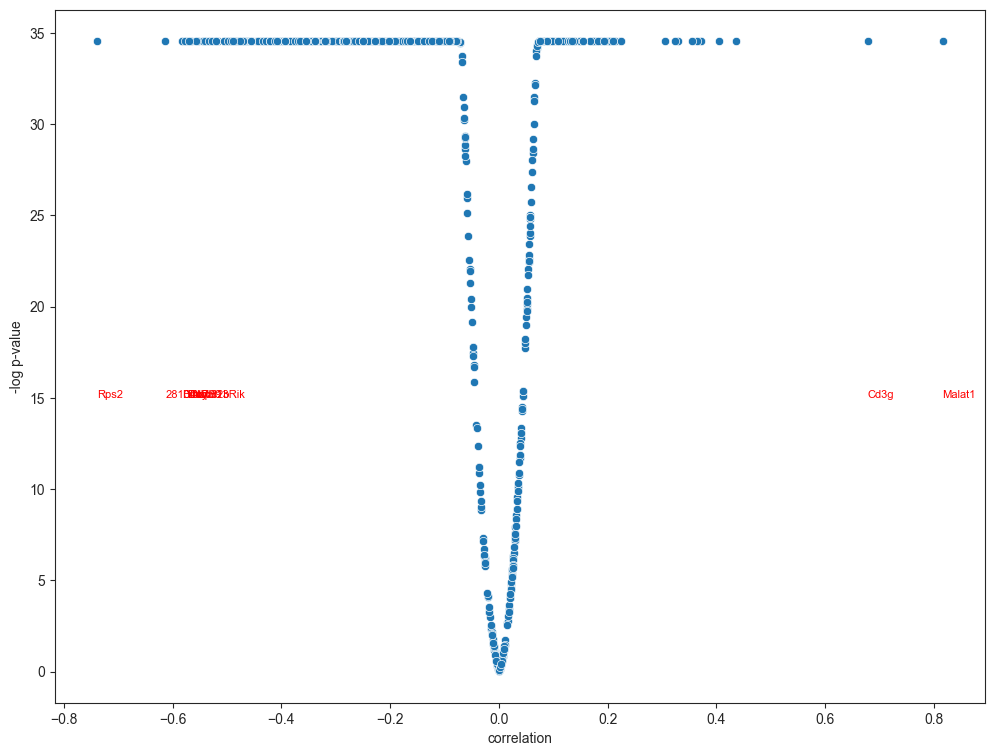

In [277]:
task2b_gene_correlations = task2b_correlation_analysis(expression_data_3, metadata_3)
task2b_gene_correlations.sort_values("abs_correlation", ascending=False).iloc[:10]\
    .to_csv(os.path.join(OUTPUT_PATH, "task2b_gene_correlations.txt"), sep="\t")

fig, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(x=task2b_gene_correlations["correlation"], y=-np.log(task2b_gene_correlations["p_value"] + 1e-15), ax=ax)
ax.set_ylabel("-log p-value");

top_10_max_correlating_genes = task2b_gene_correlations.sort_values("abs_correlation", ascending=False).head(10)
print("Top 10 correlating genes")
display(top_10_max_correlating_genes)

# Top 10 Gene markieren
for gene in top_10_max_correlating_genes.index:
    x = task2b_gene_correlations.loc[gene, "correlation"]
    y = -np.log10(task2b_gene_correlations.loc[gene, "p_value"] + 1e-15)
    ax.text(x, y, gene, fontsize=8, color="red")

plt.show()

The plot above displays a symmetric V-curve.

We can see, that many genes seem to be negatively correlated on the top left corner of the scatter-plot,
The genes displayed at around 0.0 do not seem to be correlated over time -> no correlation over time of the gene expressions.
On the top left corner, they seem to be positively correlated over time, even though, fewer points are displayed here.